**Goal**: Compare the power of pyzx optimizations - the full optimization in particular - with Cirq's optimizations - the xmon optimize method in particular.

**Methods**: 

 - direct integration between circuit representations of pyzx and Cirq: possible, but have larger maintenance burden in the future 
 - through an intermediate representation format: QASM is the common denominator - however the challenges here are that
   - the gate sets are different and require decompose/recompose 
   - the X implementation in pyzx is odd, it is set to be Rx(pi), while that is -iX - which is okay in a single qubit as it is only a global phase - but as soon as we are part of a larger setup, this might become a problem 
   - pyzx QASM import is barely functional - expression parsing is only working for limited cases 

**What statistics are we looking at for optimization?**

The following metrics: 

- **circuit depth** 
- **gate count** 

Measured **inside cirq**. We want to compare within cirq because that's where the proposed optimization would take place in the first place. 

I.e. what does it mean that one circuit is more optimal than the other? 

We should be able to create a cost function that grows in the number of gates, weighted by the expensiveness of the gate. 

How about architectural sympathy? 
 - pyxz probably does not keep that property 

Even in the Childs paper they measure **circuit depth**


In [2]:
import cirq
import pyzx as zx 
import numpy as np
import sympy as sp 
import datetime
import random
from IPython.display import display, Javascript, HTML
import json
from cirq.contrib.qasm_import.qasm import QasmCircuitParser
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg'

In [3]:
%%javascript
require.undef('pyzx')

<IPython.core.display.Javascript object>

In [4]:
# do not move

zx.d3.javascript_location = 'js'

In [14]:

quiet = False 

def qprint(*args):
    if quiet: 
        return 
    return print(*args)
    
def log(s):
    qprint('{} - {}'.format(datetime.datetime.now(), s))
    
def circ_stats(circuit): 
    qprint("depth: {}".format(len(circuit)))
    num_gates = len(list(circuit.all_operations()))
    qprint("gates: {}".format(num_gates))
    return num_gates

def compare_cirq_pyzx(qasm, draw=False):     
    stats = dict()
    log("parsing qasm to cirq...")
    
    circuit = QasmCircuitParser(qasm).parse()
    
    qprint()
    log("original in cirq:")
    qprint()
    stats['num_gates_orig'] = circ_stats(circuit)
    
    log("parsing qasm to pyzx...")
    log("original in pyzx:")
    c = zx.circuit.QASMParser().parse(qasm)
    qprint(c.stats())
    stats['num_gates_orig_pyzx'] = len(c.gates)
    
    log("converting circuit to graph...")
    g = c.to_graph()    
    if draw: 
        zx.d3.draw(c)
   
    qprint()
    log("after cirq opt:")
    qprint()

    cirq_only_opt = cirq.google.optimized_for_xmon(circuit, allow_partial_czs=True)
    stats['num_gates_opt_cirq'] = circ_stats(cirq_only_opt)
 
    qprint()
    log("GS-LC:")
    qprint()
    
    zx.simplify.full_reduce(g)
    g.normalise()
    qprint("graph size: {}".format(g.stats()))
    if draw: 
        zx.d3.draw(g)

    log("pyxz circuit extraction...")
    c = zx.extract.streaming_extract(g)
    qprint()
    log("pyzx optimized in pyzx:")
    qprint()
    stats['num_gates_opt_pyzx_in_pyzx'] = len(c.gates)
    qprint(c.stats())
    if draw: 
        zx.d3.draw(c)
#     qprint(c4.to_qasm())

    pyzx_opt_circuit = QasmCircuitParser(c.to_qasm()).parse()        
    qprint()
    qprint("after pyzx opt in cirq:")
    qprint()
    stats['num_gates_opt_pyzx_in_cirq'] = circ_stats(pyzx_opt_circuit)

    cirq_opt = cirq.google.optimized_for_xmon(pyzx_opt_circuit)
    qprint()
    qprint("after pyzx + cirq opt:")
    qprint()

    stats['num_gates_opt_pyzx_and_cirq_in_cirq'] = circ_stats(cirq_opt)

    ### CIRQ + PYZX 
    
    qprint()
    qprint("trying pyzx after cirq opt. Importing QASM to pyzx...")
    qprint()
    
    qasm = cirq_only_opt.to_qasm()  
    qprint(qasm)
    c = zx.circuit.QASMParser().parse(qasm)
    qprint(c.stats())
    
    log("converting cirq optimized circuit to graph...")
    g = c.to_graph()    
    if draw: 
        zx.d3.draw(c)

    qprint()
    log("GS-LC:")
    qprint()
    
    zx.simplify.full_reduce(g)
    g.normalise()
    qprint("cirq + pyzx optimized graph size: {}".format(g.stats()))
    if draw: 
        zx.d3.draw(g)

    log("cirq + pyzx optimized ciruit extraction...")
    c = zx.extract.streaming_extract(g)
    qprint()
    log("cirq + pyzx optimized in pyzx:")
    qprint()
    stats['num_gates_opt_cirq_pyzx_in_pyzx'] = len(c.gates)
    qprint(c.stats())
    if draw: 
        zx.d3.draw(c)
    pyzx_opt_circuit = QasmCircuitParser(c.to_qasm()).parse()        
    qprint()
    qprint("after cirq + pyzx opt in cirq:")
    qprint()
    stats['num_gates_opt_cirq_pyzx_in_cirq'] = circ_stats(pyzx_opt_circuit)

   
    #cirq.testing.circuit_compare.assert_same_circuits(pyzx_opt_circuit, circuit)
    return stats

def plot_results(data, title, cols = [ 'num_gates_orig', 
                                                 'num_gates_orig_pyzx',
                                                 'num_gates_opt_cirq', 
                                                 'num_gates_opt_pyzx_in_pyzx', 
                                                 'num_gates_opt_pyzx_in_cirq', 
                                                 'num_gates_opt_pyzx_and_cirq_in_cirq',
                                                 'num_gates_opt_cirq_pyzx_in_cirq',
                                                 'num_gates_opt_cirq_pyzx_in_pyzx',
                                     ], x_axis = 'num_gates_orig', x_label = 'original num_gates'):
    plt.rcParams["figure.figsize"] = (8, 8)

    fig, ax = plt.subplots()

    for k in [k for k in data[0].keys() if k in cols] :
        ax.scatter([d[x_axis] for d in data],[d[k] for d in data], label=k)

    ax.legend()
    ax.set(title=title)

    ax.set(xlabel=x_label, ylabel="optimized num_gates");

    
def soundness_test(qasm):
    log("parsing qasm to cirq...")

    circuit = QasmCircuitParser(qasm).parse()

    qprint()
    log("original in cirq:")
    qprint()

    log("parsing qasm to pyzx...")
    log("original in pyzx:")
    c = zx.circuit.QASMParser().parse(qasm)
    qprint(c.stats())

    log("converting circuit to graph...")
    g = c.to_graph()    


    qprint()
    log("after cirq opt:")
    qprint()

    cirq_only_opt = cirq.google.optimized_for_xmon(circuit)

    qprint()
    log("GS-LC:")
    qprint()

    zx.simplify.full_reduce(g)
    g.normalise()
    qprint("graph size: {}".format(g.stats()))

    log("pyxz circuit extraction...")
    c = zx.extract.streaming_extract(g)
    qprint()
    log("pyzx optimized in pyzx:")
    qprint()
    qprint(c.stats())

    pyzx_opt_circuit = QasmCircuitParser(c.to_qasm()).parse()

    log("calculating unitaries:")

    log("pyzx optimized circuit...")
    po = cirq.unitary(pyzx_opt_circuit)
    log("cirq optimized circuit...")
    co = cirq.unitary(cirq_only_opt)
    log("original circuit...")
    c = cirq.unitary(circuit)
    log("comparing original circuit to cirq optimized...")
    cirq.testing.assert_allclose_up_to_global_phase(c,co,atol=1e-7)
    log("c matches co")
    log("comparing pyzx optimized circuit to cirq optimized...")
    cirq.testing.assert_allclose_up_to_global_phase(po,co,atol=1e-7)
    log("po matches co")   

In [5]:
# The example from the paper 

quiet = False
random.seed(1344) 
g = zx.generate.cliffordT(4,350,p_t=0.010)
qasm =  zx.extract.streaming_extract(g).to_qasm()

compare_cirq_pyzx(qasm, draw=True)


2019-05-25 15:55:28.380382 - parsing qasm to cirq...

2019-05-25 15:55:28.577563 - original in cirq:

depth: 173
gates: 350
2019-05-25 15:55:28.577746 - parsing qasm to pyzx...
2019-05-25 15:55:28.577770 - original in pyzx:
Circuit  on 4 qubits with 350 gates.
        4 is the T-count
        346 Cliffords among which 
        109 2-qubit gates and 0 Hadamard gates.
2019-05-25 15:55:28.583444 - converting circuit to graph...



2019-05-25 15:55:28.601812 - after cirq opt:

depth: 141
gates: 229

2019-05-25 15:55:29.751408 - GS-LC:

graph size: Graph(20 vertices, 44 edges)
degree distribution: 
1: 8
3: 1
4: 1
5: 2
6: 1
7: 2
8: 2
9: 3



2019-05-25 15:55:29.810672 - pyxz circuit extraction...

2019-05-25 15:55:29.812308 - pyzx optimized in pyzx:

Circuit  on 4 qubits with 45 gates.
        4 is the T-count
        41 Cliffords among which 
        21 2-qubit gates and 14 Hadamard gates.


TypeError: Gate SWAP(0,3) doesn't have a QASM description

In [10]:
# What's the smallest that we still see a benefit? 

# random.seed(1344) 

num_trials = 5 
range_gates = range(10,500,50)

data = []
quiet = True
for num_gate in range_gates:     
    quiet = False
    log("running {}".format(num_gate))
    quiet = True
    for trial in range(num_trials):
        g = zx.generate.cliffordT(4,num_gate,p_t=0.010)
        qasm =  zx.extract.streaming_extract(g).to_qasm()
        results = compare_cirq_pyzx(qasm)        
        data.append(results)

2019-05-23 19:11:59.375904 - running 10
2019-05-23 19:12:00.205236 - running 60
2019-05-23 19:12:02.349138 - running 110
2019-05-23 19:12:05.694290 - running 160
2019-05-23 19:12:10.231437 - running 210
2019-05-23 19:12:16.776890 - running 260
2019-05-23 19:12:23.769595 - running 310
2019-05-23 19:12:32.852827 - running 360
2019-05-23 19:12:41.472757 - running 410
2019-05-23 19:12:51.866462 - running 460


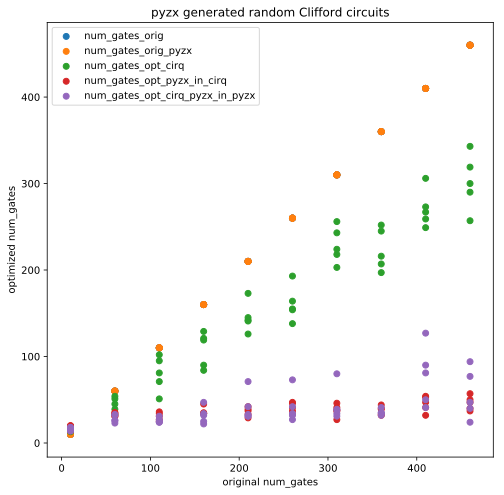

In [12]:
plot_results(data, "pyzx generated random Clifford circuits", cols = [ 
                                                 'num_gates_orig', 
                                                 'num_gates_orig_pyzx',
                                                 'num_gates_opt_cirq', 
#                                                  'num_gates_opt_pyzx_in_pyzx', 
                                                 'num_gates_opt_pyzx_in_cirq', 
#                                                  'num_gates_opt_pyzx_and_cirq_in_cirq',
#                                                  'num_gates_opt_cirq_pyzx_in_cirq',
                                                 'num_gates_opt_cirq_pyzx_in_pyzx',
                                     ])

2019-05-23 19:28:04.731373 - running with 1% T gates
2019-05-23 19:28:45.144210 - running with 11% T gates
2019-05-23 19:29:34.521455 - running with 21% T gates
2019-05-23 19:30:20.203638 - running with 31% T gates
2019-05-23 19:31:05.035435 - running with 41% T gates
2019-05-23 19:31:44.969428 - running with 51% T gates
2019-05-23 19:32:24.398465 - running with 61% T gates
2019-05-23 19:35:34.935850 - running with 71% T gates


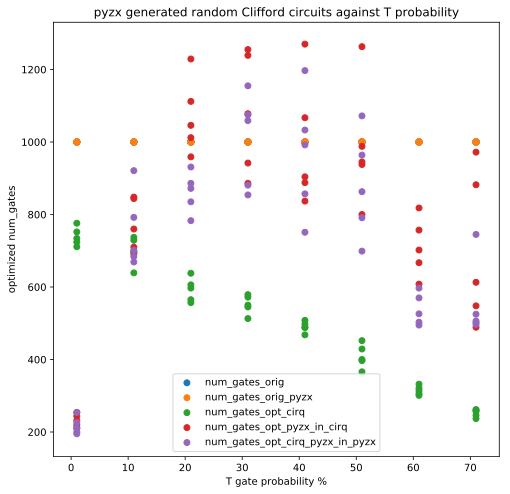

In [19]:
# Run experiment on fixed gate count but changing T gate probability 

num_trials = 5 
range_t = range(1,80,10)

data = []
quiet = True
for t_prob in range_t:     
    quiet = False
    log("running with {}% T gates".format(t_prob))
    quiet = True
    for trial in range(num_trials):
        g = zx.generate.cliffordT(12,1000,p_t=0.01 * t_prob)
        qasm =  zx.extract.streaming_extract(g).to_qasm()
        results = compare_cirq_pyzx(qasm)        
        results['t_prob'] = t_prob
        data.append(results)


In [180]:
# The OpenFermion Hubbard simulation examples

quiet = True
sim_data = []

for n_steps in range(1,20,2): 
    quiet = False
    log("running {}".format(n_steps))
    quiet = True
    qasm = open('/Users/balintp/dev/proj/pyzx/hubbard_sim_{}.qasm'.format(n_steps)).read()
    results = compare_cirq_pyzx(qasm) 
    sim_data.append(results)

2019-05-23 12:22:30.771932 - running 1
2019-05-23 12:22:50.736943 - running 3
2019-05-23 12:23:48.871311 - running 5
2019-05-23 12:25:20.718086 - running 7
2019-05-23 12:27:18.059826 - running 9
2019-05-23 12:29:54.739156 - running 11
2019-05-23 12:33:08.960885 - running 13
2019-05-23 12:37:06.136115 - running 15
2019-05-23 12:41:43.942096 - running 17
2019-05-23 12:46:50.390775 - running 19


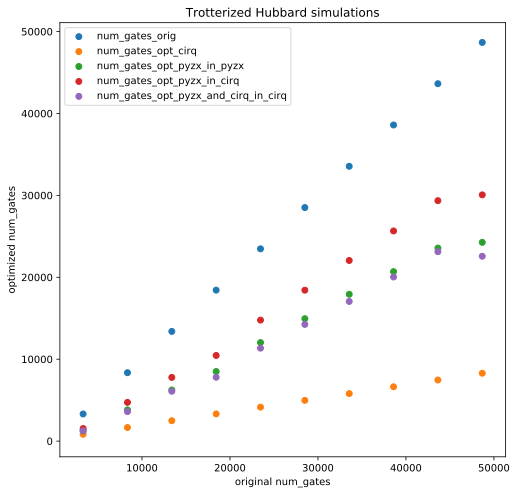

In [181]:

plot_results(sim_data, "Trotterized Hubbard simulations")

In [144]:
# The OpenFermion LiH example 
quiet = False 
qasm = open('/Users/balintp/dev/proj/pyzx/lih.qasm').read()

compare_cirq_pyzx(qasm)

2019-05-23 10:51:36.721303 - parsing qasm to cirq...
2019-05-23 10:52:16.884179 - parsing qasm to pyzx...
2019-05-23 10:52:19.125204 - converting circuit to graph...

2019-05-23 10:52:21.385229 - original:

depth: 39640
gates: 61820

2019-05-23 10:52:21.402371 - after cirq opt:

depth: 8484
gates: 35547

2019-05-23 10:55:45.021325 - GS-LC:

graph size: Graph(7477 vertices, 40237 edges)
degree distribution: 
1: 2738
2: 348
3: 676
4: 459
5: 271
6: 192
7: 227
8: 205
9: 122
10: 64
11: 81
12: 73
13: 146
14: 234
15: 321
16: 292
17: 168
18: 121
19: 81
20: 69
21: 73
22: 60
23: 70
24: 46
25: 47
26: 33
27: 9
28: 19
29: 18
30: 24
31: 15
32: 13
33: 8
34: 11
35: 7
36: 10
37: 8
38: 9
39: 3
40: 8
41: 10
42: 4
43: 3
44: 1
45: 3
46: 2
47: 1
48: 2
50: 1
51: 2
75: 1
78: 1
98: 1
125: 1
130: 1
139: 1
140: 1
141: 1
144: 2
145: 1
146: 1
147: 2
149: 1
151: 2
154: 1
156: 2
157: 1
158: 1
165: 1
167: 1
205: 1
208: 1
209: 1
212: 1
214: 1
219: 1
221: 2
222: 1
228: 1
230: 1
232: 2
233: 1
262: 1
263: 1
270: 1
277: 3

{'num_gates_orig': 61820,
 'num_gates_opt_cirq': 35547,
 'num_gates_opt_pyzx_in_pyzx': 37455,
 'num_gates_opt_pyzx_in_cirq': 53821,
 'num_gates_opt_pyzx_and_cirq_in_cirq': 43136}

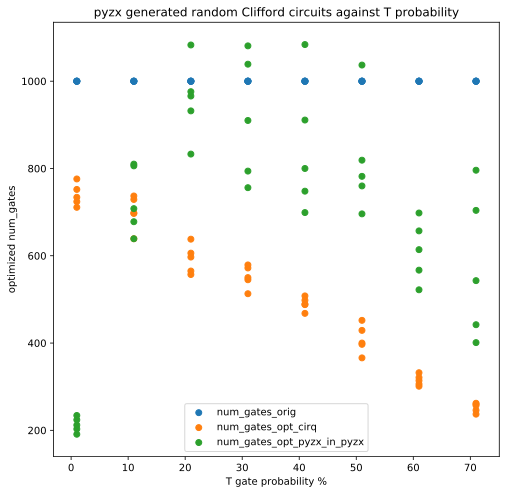

In [24]:
plot_results(data, "pyzx generated random Clifford circuits against T probability", cols = [ 
                                                 'num_gates_orig', 
#                                                  'num_gates_orig_pyzx',
                                                 'num_gates_opt_cirq', 
                                                 'num_gates_opt_pyzx_in_pyzx', 
#                                                  'num_gates_opt_pyzx_in_cirq', 
#                                                  'num_gates_opt_pyzx_and_cirq_in_cirq',
#                                                  'num_gates_opt_cirq_pyzx_in_cirq',
#                                                  'num_gates_opt_cirq_pyzx_in_pyzx',
                                     ], x_axis = 't_prob', x_label = 'T gate probability %')

In [1]:
import pyzx as zx 

qasm = """
OPENQASM 2.0;
include "qelib1.inc";
qreg q[4];
u3(pi*0.5,pi*1.25,pi*1.0) q[2];
u2(pi*-0.25, pi*0.25) q[0];
rx(0.5*pi) q[1];
rx(1*pi) q[2];
h q[3];
rz(0.5*pi) q[3];
h q[3];
"""
        
c3 = zx.circuit.QASMParser().parse(qasm)
g = c3.to_graph()
zx.d3.draw(c3)

zx.full_reduce(g)
zx.d3.draw(g)
g.normalise()


zx.clifford_simp(g)
c4 = zx.extract.streaming_extract(g)
zx.d3.draw(c4)
print(c4.to_qasm())


id_simp: 2.  1 iterations


OPENQASM 2.0;
include "qelib1.inc";
qreg q[4];
h q[2];
rz(1.25*pi) q[2];
rz(1.25*pi) q[0];
h q[1];
rz(0.5*pi) q[1];
h q[3];
rz(0.5*pi) q[3];
h q[0];
rz(1.75*pi) q[0];
h q[2];
rz(1.0*pi) q[2];
h q[1];
h q[2];
h q[3];



In [ ]:

zx.d3.draw(g)
log('zx full_reduce...')
zx.simplify.full_reduce(g, quiet=True)
log('zx normalize...')
g.normalise()
log('zx streaming extract...')
new_circ = zx.extract.streaming_extract(g)
log('export to qasm - stats: ...'.format(new_circ.stats()))
print(new_circ.to_qasm())
print(new_circ)
c4 = QasmCircuitParser(new_circ.to_qasm()).parse()
log(len(c4))
print(c4)
zx.d3.draw(new_circ.to_graph())


from cirq.contrib.quirk import circuit_to_quirk_url

print(circuit_to_quirk_url(circuit))



import sys;
import random
import pyzx as zx
from cirq.contrib.qasm_import.qasm import QasmCircuitParser

%config InlineBackend.figure_format = 'svg'
random.seed(1344) # Make sure the same circuit is generated
g = zx.generate.cliffordT(4,350,p_t=0.010)

ty = {1: 'Z', 2: 'X'}
def typeOf(t): 
    if t in ty: 
        return ty[t]
    return t

zx.d3.javascript_location = 'js'
zx.d3.draw(g)
for v in g.vertices():
    print("{}: {}({})[{}]".format(v, typeOf(g.type(v)) , '' if g.phase(v) == 0 else g.phase(v), g.qubit(v)))
    
g2 = g.copy()

qasm1 = zx.extract.streaming_extract(g).to_qasm()

print(qasm1)
cirq1 = QasmCircuitParser(qasm1).parse()
print(cirq1)

zx.full_reduce(g2)
g2.normalise()
zx.d3.draw(g2)

In [10]:
cirq.unitary(cirq.Y)

array([[0.+0.j, 0.-1.j],
       [0.+1.j, 0.+0.j]])

In [13]:
1j * cirq.unitary(cirq.Ry(np.pi))

array([[ 0.+0.j, -0.-1.j],
       [ 0.+1.j,  0.+0.j]])

In [26]:
# Equality test 
 

for qubits in range(2,6):
    for num_gates in range(10, 100,20):
        for prob_t in range(1,40,10):  
            quiet = False
            log("checking {}-{}-{}%...".format(qubits, num_gates, prob_t))
            quiet = True
            g = zx.generate.cliffordT(qubits,num_gates,p_t=(0.010*prob_t))
            qasm =  zx.extract.streaming_extract(g).to_qasm()
            soundness_test(qasm)

2019-05-24 06:14:40.052389 - checking 2-10-1%...
2019-05-24 06:14:40.125805 - checking 2-10-11%...
2019-05-24 06:14:40.193814 - checking 2-10-21%...
2019-05-24 06:14:40.264008 - checking 2-10-31%...
2019-05-24 06:14:40.323505 - checking 2-30-1%...
2019-05-24 06:14:40.454453 - checking 2-30-11%...
2019-05-24 06:14:40.568264 - checking 2-30-21%...
2019-05-24 06:14:40.682432 - checking 2-30-31%...
2019-05-24 06:14:40.776546 - checking 2-50-1%...
2019-05-24 06:14:40.975485 - checking 2-50-11%...
2019-05-24 06:14:41.146613 - checking 2-50-21%...
2019-05-24 06:14:41.327039 - checking 2-50-31%...
2019-05-24 06:14:41.470381 - checking 2-70-1%...
2019-05-24 06:14:41.683442 - checking 2-70-11%...
2019-05-24 06:14:41.895358 - checking 2-70-21%...
2019-05-24 06:14:42.089427 - checking 2-70-31%...
2019-05-24 06:14:42.294756 - checking 2-90-1%...
2019-05-24 06:14:42.557121 - checking 2-90-11%...
2019-05-24 06:14:42.824598 - checking 2-90-21%...
2019-05-24 06:14:43.069943 - checking 2-90-31%...
2019-

In [7]:
quiet = False
qasm = """
OPENQASM 2.0;
include "qelib1.inc";
qreg q[2];
u3(1.5,2.3,3.4) q[0];
u2(1.5,2.3) q[1];
y q[0];
ry(6.3*pi) q[1];
"""
soundness_test(qasm) 

2019-05-24 11:50:14.773525 - parsing qasm to cirq...

2019-05-24 11:50:14.794443 - original in cirq:

2019-05-24 11:50:14.794514 - parsing qasm to pyzx...
2019-05-24 11:50:14.794542 - original in pyzx:
Circuit  on 2 qubits with 4 gates.
        6 is the T-count
        0 Cliffords among which 
        0 2-qubit gates and 0 Hadamard gates.
There are 4 gates of a different type
2019-05-24 11:50:14.795036 - converting circuit to graph...

2019-05-24 11:50:14.795551 - after cirq opt:


2019-05-24 11:50:14.802702 - GS-LC:

graph size: Graph(11 vertices, 9 edges)
degree distribution: 
1: 4
2: 7

2019-05-24 11:50:14.806556 - pyxz circuit extraction...

2019-05-24 11:50:14.807082 - pyzx optimized in pyzx:

Circuit  on 2 qubits with 12 gates.
        6 is the T-count
        6 Cliffords among which 
        0 2-qubit gates and 5 Hadamard gates.
2019-05-24 11:50:14.832460 - calculating unitaries:
2019-05-24 11:50:14.832575 - pyzx optimized circuit...
2019-05-24 11:50:14.833847 - cirq optimized c

In [10]:
quiet = False 
qasm = open('/Users/balintp/dev/proj/pyzx/hubbard_sim_1.qasm').read()
soundness_test(qasm) 

2019-05-24 11:03:06.783643 - parsing qasm to cirq...

2019-05-24 11:03:08.917506 - original in cirq:

2019-05-24 11:03:08.917561 - parsing qasm to pyzx...
2019-05-24 11:03:08.917589 - original in pyzx:
Circuit  on 12 qubits with 3312 gates.
        1122 is the T-count
        2166 Cliffords among which 
        858 2-qubit gates and 0 Hadamard gates.
There are 1122 gates of a different type
2019-05-24 11:03:09.043123 - converting circuit to graph...

2019-05-24 11:03:09.165418 - after cirq opt:


2019-05-24 11:03:17.567611 - GS-LC:

graph size: Graph(152 vertices, 543 edges)
degree distribution: 
1: 62
3: 13
4: 13
5: 3
6: 6
7: 6
8: 4
9: 3
10: 4
11: 2
12: 11
13: 3
16: 1
17: 1
19: 1
20: 1
21: 1
23: 5
24: 3
25: 1
26: 1
27: 3
29: 1
33: 1
35: 1
39: 1

2019-05-24 11:03:18.453339 - pyxz circuit extraction...

2019-05-24 11:03:18.613028 - pyzx optimized in pyzx:

Circuit  on 12 qubits with 1254 gates.
        82 is the T-count
        1172 Cliffords among which 
        374 2-qubit gates and 7

In [47]:
# A small enough instance where we see advantage over cirq

# Interestingly if p_cnot = 0 - cirq wins! 

quiet = True
# random.seed(1344) 
g = zx.generate.cliffordT(4,150,p_t=0.0, p_cnot=0.3)
qasm =  zx.extract.streaming_extract(g).to_qasm()

compare_cirq_pyzx(qasm, draw=False)

{'num_gates_orig': 150,
 'num_gates_orig_pyzx': 150,
 'num_gates_opt_cirq': 103,
 'num_gates_opt_pyzx_in_pyzx': 23,
 'num_gates_opt_pyzx_in_cirq': 25,
 'num_gates_opt_pyzx_and_cirq_in_cirq': 27,
 'num_gates_opt_cirq_pyzx_in_pyzx': 26,
 'num_gates_opt_cirq_pyzx_in_cirq': 30}

In [56]:

quiet = True
random.seed(1344) 
g = zx.generate.cliffordT(4,300,p_t=0.50, p_cnot=0.02)
qasm =  zx.extract.streaming_extract(g).to_qasm()

compare_cirq_pyzx(qasm, draw=False)

{'num_gates_orig': 300,
 'num_gates_orig_pyzx': 300,
 'num_gates_opt_cirq': 21,
 'num_gates_opt_pyzx_in_pyzx': 52,
 'num_gates_opt_pyzx_in_cirq': 56,
 'num_gates_opt_pyzx_and_cirq_in_cirq': 28,
 'num_gates_opt_cirq_pyzx_in_pyzx': 34,
 'num_gates_opt_cirq_pyzx_in_cirq': 46}

In [10]:
# pauli optimizer doesn't help 

quiet = False
random.seed(1354) 
g = zx.generate.cliffordT(4,50,p_t=0.010)
qasm =  zx.extract.streaming_extract(g).to_qasm()

circuit = QasmCircuitParser(qasm).parse()
    
qprint()
log("original in cirq:")
qprint()
circ_stats(circuit)

from cirq.contrib.paulistring import optimized_circuit

c = optimized_circuit(circuit, repeat=50)

circ_stats(c)

print(c)


2019-05-25 16:07:13.450719 - original in cirq:

depth: 25
gates: 50
depth: 18
gates: 35
                                      ┌──┐                                                                      ┌──┐                ┌──┐
q_0: ───@───────Y^-0.5───@───Y^-0.5─────@────X^-0.5───────────────@───(Z^-0.5-X^0.5)───@───Y^0.5──────────────────@────(Z-Y^-0.5)─────@────(X^-0.5-Z^0.5)───
        │                │              │                         │                    │                          │                   │
q_1: ───@───────X^-0.5───@───X^0.5─────@┼─────────────@───X^0.5───┼────────────────────@───@───────X^-0.5───@────@┼────X^0.5─────────@┼────(Z-Y^-0.5)───────
                                       ││             │           │                        │                │    ││                  ││
q_2: ──────────────────────────────────┼@────X^0.5────@───X^0.5───@───@────────────────────┼────────────────┼────@┼────X^-0.5────────@┼────X────────────────
                               

In [49]:
# Run experiment on fixed gate count but changing T gate probability 

num_trials = 5 
range_t = range(1,82,10)

data = []
quiet = True
for t_prob in range_t:     
    quiet = False
    log("running with {}% CNOT gates".format(t_prob))
    quiet = True
    for trial in range(num_trials):
        g = zx.generate.cliffordT(12,300,p_t = 0.01, p_cnot=0.01 * t_prob)
        qasm =  zx.extract.streaming_extract(g).to_qasm()
        results = compare_cirq_pyzx(qasm)        
        results['t_prob'] = t_prob
        data.append(results)


2019-05-25 17:43:56.722204 - running with 1% CNOT gates
2019-05-25 17:43:59.899533 - running with 11% CNOT gates
2019-05-25 17:44:07.649091 - running with 21% CNOT gates
2019-05-25 17:44:18.004274 - running with 31% CNOT gates
2019-05-25 17:44:31.002046 - running with 41% CNOT gates
2019-05-25 17:44:45.910585 - running with 51% CNOT gates
2019-05-25 17:45:02.238495 - running with 61% CNOT gates
2019-05-25 17:45:21.041224 - running with 71% CNOT gates


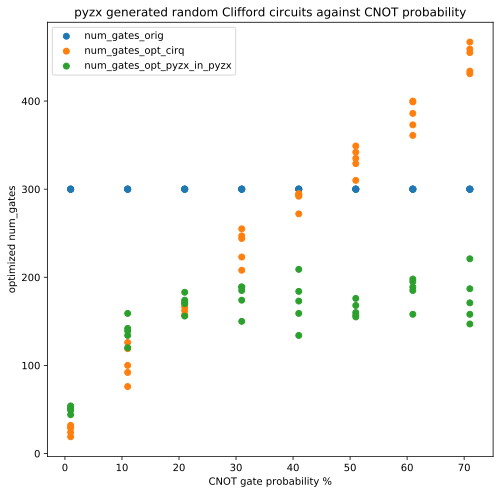

In [51]:
plot_results(data, "pyzx generated random Clifford circuits against CNOT probability", cols = [ 
                                                 'num_gates_orig', 
#                                                  'num_gates_orig_pyzx',
                                                 'num_gates_opt_cirq', 
                                                 'num_gates_opt_pyzx_in_pyzx', 
#                                                  'num_gates_opt_pyzx_in_cirq', 
#                                                  'num_gates_opt_pyzx_and_cirq_in_cirq',
#                                                  'num_gates_opt_cirq_pyzx_in_cirq',
#                                                  'num_gates_opt_cirq_pyzx_in_pyzx',
                                     ], x_axis = 't_prob', x_label = 'CNOT gate probability %')